# Подбор гиперпараметров для алгоритма LogisticRegression на примере Breast Cancer Data

Для начала работы загруим необходимые библиотеки и инструменты 

In [66]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pylab import rcParams
import mglearn
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, f1_score

В качестве рабочего набора данных будет использован встроенный набор данных breast_cancer, содержащий в себе 569 записей и информацию по 9 признакам. Для каждого из этих признаков были рассчитаны среднее значение, стандартная ошибка и «наихудшее» или наибольшее (среднее из трех самых больших значений) значение, что дало 30 признаков. Каждая из записей данных имеет метку Malignant (злокачественная опухоль) (212 записей) или Benign(доброкачественная опухоль) (357).

In [3]:
cancer = load_breast_cancer()

In [227]:
print(cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

Для начала произведем разбиение обучающего набора для построения модели на 3 части: обучающий набор для построения модели, проверочный (валидационный) набор для выбора параметров модели, тестовый набор для оценки качества работы выбранных параметров.

In [4]:
#Разбивка данных на обчающий, проверочный и тестовый наборы

X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

Задача: обучить классификатор с целью получения наилучших критериев правильности, F-меры, точности и полноты.
Т.к. данные содержат информацию о двух классах (Malignant и Benign), то имеем дело с бинарной классификацией.

В качестве рабочей модели выбрана Логистическая регрессия.

### Ручная оптимизация гиперпараметра C

Первоначально посмотрим, как ведет себя показатель правильности при разных значениях гиперпараметра С. Будем с использовать кросс валидацию, чтобы получить более обобщающую способность модели и не получить слишком оптимистичные результаты.

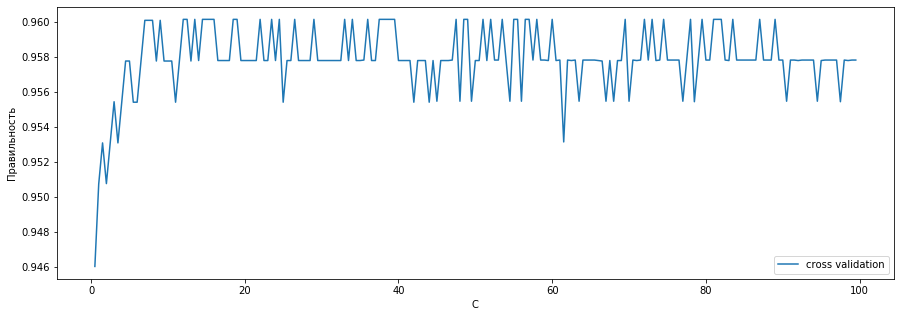

In [229]:
# Рассмотрим параметр C на интервале от 0 до 100 с шагом 0.5

param = np.arange(0,100,0.5)
scores = []
for c in param[1:]:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(param[1:], scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 15

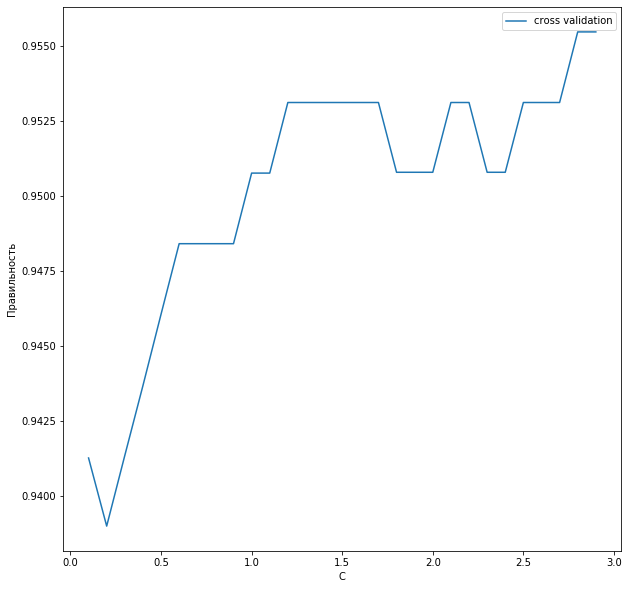

In [274]:
param = np.arange(0,3,0.1)
scores = []
for c in param[1:]:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(param[1:], scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 15

На графике отражено, что показатель правильности достигает максимальной правильности в области, не доходящей до С = 10.
Рассмотрим подробнее этот участок.

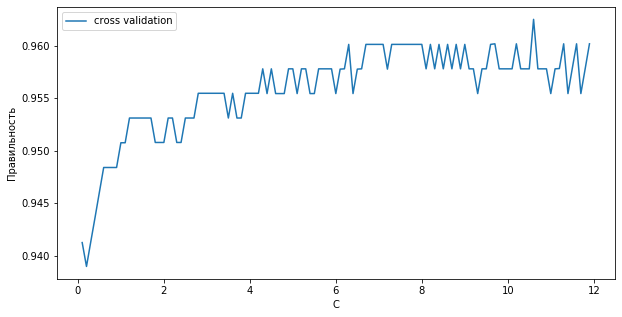

In [231]:
n = np.arange(0,12,0.1, dtype=float)

param = []
scores = []
for c in n[1:]:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(n[1:], scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 5

Видно, что график колеблется и достигает высоких значениях в интервале от 10 до 11.
Рассмотрим этот участок.

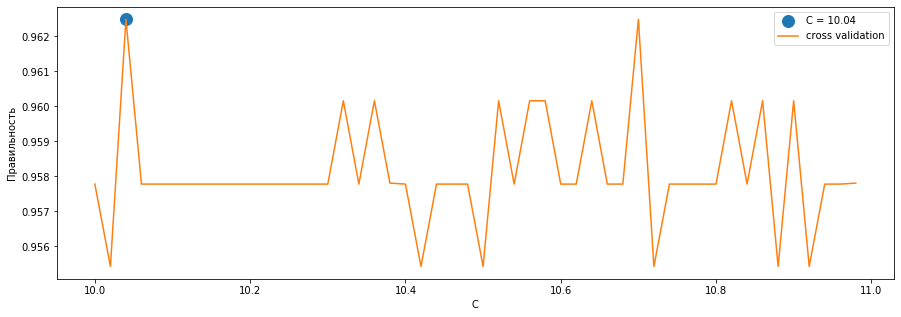

In [18]:
n = np.arange(10,11,0.02, dtype=float)

scores = []
for c in n:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

max_point = np.argmax(np.abs(scores))
plt.plot(n[max_point], scores[max_point],'o', markersize=12, label = 'C = {}'.format(n[max_point]))        
plt.plot(n, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 5

Рассмотрим 2 участка, достигающие максимального показателя правильности. Рассчитаем для них точное значение показателя С.

Промежуток [10.0-10.2]
Наибольшее значение правильности, равное 0.962
при С = 10.04

Промежуток [10.7-10.7]
Наибольшее значение правильности, равное 0.960
при С = 10.7



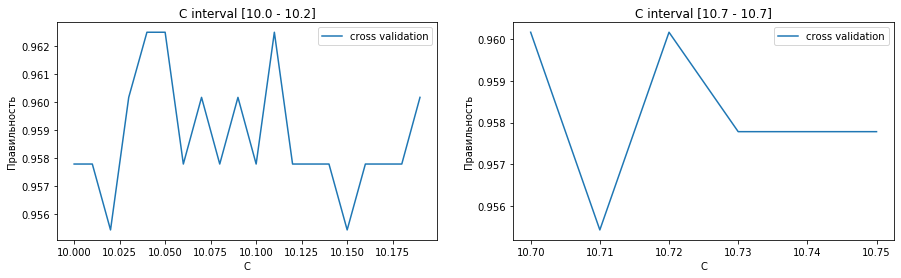

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) 

# задаем участки
sector_1 = np.arange(10,10.2,0.01, dtype=float) 
sector_2 = np.arange(10.7,10.75,0.01, dtype=float)

for sector,ax in zip([sector_1,sector_2], axes):
    scores = []
    for point in sector:
        log_reg = LogisticRegression(C = point)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
        scores.append(np.mean(scor))
    ax.set_title("C interval [{} - {}]".format(sector[0],round(sector[-1],1)))    
    ax.plot(sector, scores,label = 'cross validation')
    ax.set_ylabel("Правильность")
    ax.set_xlabel("C")
    ax.legend(loc = 'best')
    ax.plot()
    
    # определяем максимальное значение правильности на заданном интервале
    max_score = 0                        
    for item in scores:
        if item > max_score:
            max_score = item
            
    # при каком значении С достигается max значение
    max_C = []                           
    for k in range(len(scores)):
        if scores[k] == max_score:
            max_C.append(sector[k])
            
    print ('Промежуток [{}-{}]'.format(sector[0],round(sector[-1],1)))
    print('Наибольшее значение правильности, равное {:.3f}'.format(max_score))
    print('при С = {}\n'.format(*max_C))

После ручного поиска показателя С с макимальной правильностью мы добились правильности при кросс валидации в 96%.

### Процесс отбора параметров и оценки модели с помощью решетчатого поиска (GridSearchCV)

В качестве параметра С зададим вектор с участком, котороый мы старались оптимизировать вручную - [10,20]

In [234]:
c = np.arange(10,20,0.01)  
param_grid = {'C': c}
GScv = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
GScv.fit(X_trainval,y_trainval)
print('Луший параметр {}'.format(GScv.best_params_))
print('Средняя точность кросс валидации при параметре {} равна {:.3f}'.format(GScv.best_params_,GScv.best_score_))

Луший параметр {'C': 10.04}
Средняя точность кросс валидации при параметре {'C': 10.04} равна 0.962


### Разбиение на блоки при кросс валидации

Рассмотрим, как на показатель правильности влияет количество блоков, на которые разбиваются тренировочные данные при кросс валидации.

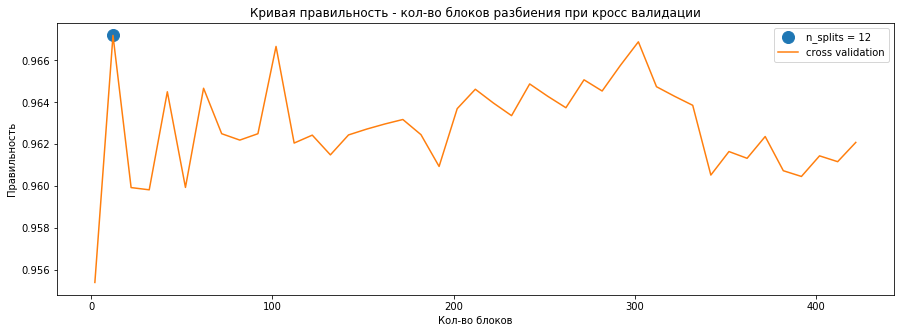

In [17]:
blocks = np.arange(2,X_trainval.shape[0],10)
scores = []
for b in blocks:
    kf = KFold(n_splits=b)
    log_reg = LogisticRegression(C = 10.04)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
    scores.append(np.mean(scor))
    

max_point = np.argmax(np.abs(scores))
plt.plot(blocks[max_point], scores[max_point],'o', markersize=12, label = 'n_splits = {}'.format(blocks[max_point]))        
plt.plot(blocks, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("Кол-во блоков")
plt.title('Кривая правильность - кол-во блоков разбиения при кросс валидации')
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 15, 5


In [29]:
scores = []
for i in [5,10,12,426]:
    kf = KFold(n_splits=i)
    log_reg = LogisticRegression(C = 10.04)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
    scores.append(np.mean(scor))
    print('Правильность кросс валидации при разбиении на {} блоков = {:.3f}'.format(i,np.mean(scor)))

print()    
log_reg.fit(X_trainval, y_trainval)  
test_rezult = log_reg.score(X_test,y_test)
print("Правильность на тестовом наборе: {:.3f}".format(test_rezult))


Правильность кросс валидации при разбиении на 5 блоков = 0.962
Правильность кросс валидации при разбиении на 10 блоков = 0.963
Правильность кросс валидации при разбиении на 12 блоков = 0.967
Правильность кросс валидации при разбиении на 426 блоков = 0.962

Правильность на тестовом наборе: 0.937


Последнее значение (разбиение на 426 блоков) соответствует перекрестной проверке с исключением по 1.
Данные размера k разбиваются на k блоков, таким образом, в тестовом множестве содержится только 1 пример. По итогу такой проверки получается, что каждый пример данных был по 1 разу в тестовом наборе. 

#### LeaveOneOut CV

Для осуществления перекрестной проверки с исключением по одному в sklearn есть специальный метод.

In [318]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
log_reg = LogisticRegression(C = 10.04)
scores = cross_val_score(log_reg, X_trainval,y_trainval, cv=loo)
print("Количество итераций: ", len(scores))
print("Средняя правильность: {:.3f}".format(scores.mean()))

Количество итераций:  426
Средняя правильность: 0.962


Как видно по графику, количество блоков разбиения имеет влияние при кросс валидации. 
Оптимальным (и по умолчанию заданным) является разбиение на 5 фолдов.
При разбиении следует учесть, чтобы данные, входящие в блок, должны быть репрезентативными.

По графику при параметре C = 10.04 и cv = 12 достигается правильность больше 96,6%. 

Показатель точности при значении по умолчанию (cv = 5) отличается от оптимизированного на 0.05.

Это можно объяснить тем, что модель обучается на большем кол-ве данных и в то же время тестируется на меньшем кол-ве.

при 12 блоках:
426/12= 35.5 записей в блоке - 
на 35.5 данных модель тестируется, на 390.5 - модель обучается

при 3 блоках:
426/5 = 85.2 записей в блоке - 
на 85.2 данных модель тестируется, на 340.8 - модель обучается

##  Точность на тестовых данных с подобранным параметром С

In [30]:
log_reg = LogisticRegression(C = 10.04).fit(X_train,y_train)
print("Правильность на обучающем наборе: {:.3f}".format(log_reg.score(X_valid, y_valid)))
print("Правильность на тестовом наборе: {:.3f}".format(log_reg.score(X_test, y_test)))

Правильность на обучающем наборе: 0.981
Правильность на тестовом наборе: 0.937


C = 3e-05 правильность = 0.93 AUC = 0.95
C = 0.001 правильность = 0.92 AUC = 0.97
C = 10.4 правильность = 0.94 AUC = 0.99


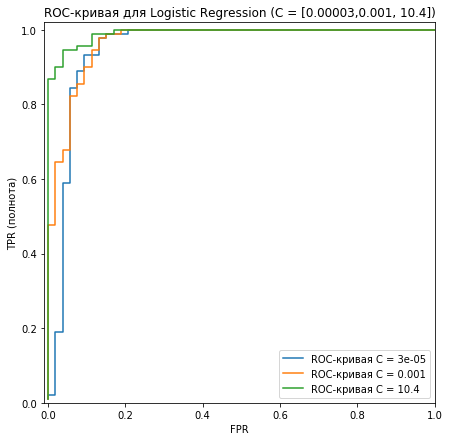

In [31]:
for i in [0.00003, 0.001, 10.4]:
    log_reg = LogisticRegression(C = i).fit(X_trainval,y_trainval)
    accuracy = log_reg.score(X_test, y_test)
    auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, log_reg.decision_function(X_test))
    print("C = {} правильность = {:.2f} AUC = {:.2f}".format(i,accuracy, auc))
    plt.plot(fpr, tpr,  label="ROC-кривая C = {}".format(i))
    
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.title('ROC-кривая для Logistic Regression (C = [0.00003,0.001, 10.4])')
plt.legend()
rcParams['figure.figsize'] = 7, 7
plt.show()

При C = 10.04 ROC кривая приближена к левому верхнему углу, что соответствует тому, что модель имеет маленькое кол-во ложно положительных результатов (определяет класс 0 как класс 1) (низкая вероятность совершить ошибку первого рода) и достаточно высокую полноту, т.е. алгоритм выделяет достаточно много истинных объектов 1 класса. Площадь под кривой (AUC) равна 99, что также говорит о хорошей работе алгоритма.

При высоких параметрах С модель логистической регрессии старается точно определить каждую метку. Высока вероятность переобучения. Однако, в нашем случае модель дала хорошие результаты: 98% точности на тренировочных данных и 94% на тестовых.

## Установка порогового значения по вероятности

Изначально порог принятия реения для решающей функции задан 0: 

* при значении решающей функции < 0, объект относится к классу 0

* при значении решающей функции > 0, объект относится к классу 1


Для вероятности установлен порог принятия решений = 0.5:

* при вероятности < 0.5, объект относится к классу 0 (модель уверена меньше)
* при вероятности > 0.5, объект относится к классу 1 (модель уверена больше)

Эти параметры можно менять для оптимизации модели под требования бизнес задачи.

В исследуемом наборе имеется 2 класса: 
* 'malignant' = 0 (злокачественные опухоли) 
* 'benign' = 1 (доброкачественные опухоли) 

Поставим перед собой следующую задачу: минимизировать долю ложно-положительных результатов, т.е. тех случаев, когда алгоритм предсказывает, что опухоль яв-ся доброкачественной (1), а на самом деле опухоль яв-ся злокачественной (0). В таком случае мы хотим быть уверены, что те пациенты, у кого высокая вероятность доброкачественной опухоли, буду определены алгоритмом точно. Тогда модель должна иметь бОльший порог уверенности, относя пациента к классу 1 и стремиться к 100%  точности в этм классе.

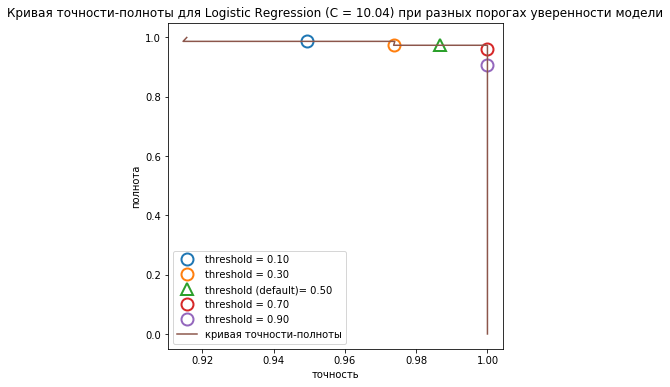

In [220]:
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

# изначально порог на decision_function = 0, redict_proba = 0.5

log_reg = LogisticRegression(C = 10.04) 
log_reg.fit(X_train, y_train) 

precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])

rcParams['figure.figsize'] = 6, 6
for i in np.arange(0.1,1,0.2):
    if round(i,1) == 0.5:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], '^',
                 markersize=12, label="threshold (default)= {:.2f}".format(i), fillstyle="none", mew=2) 
    else:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], 'o',
             markersize=12, label="threshold = {:.2f}".format(i), fillstyle="none", mew=2) 
    
plt.plot(precision, recall, label = 'кривая точности-полноты')
plt.xlabel('точность')
plt.ylabel('полнота')
plt.title('Кривая точности-полноты для Logistic Regression (C = 10.04) при разных порогах уверенности модели')
plt.legend(loc = 'best')
plt.show()

Выведем сводку по показателям точности, полноты и их гармонического среднего (f-меры).

Видим, что алгоритм очень хорошо (100%) определяет пациентов с доброкачественной опухолью и отлично выявляет всех больных пациентов.

In [202]:
print('tresholds = 0.5')
print(classification_report(y_valid,log_reg.predict(X_valid))) 
print()
print('tresholds = 0.7')
y_pred_rise_threshold = log_reg.predict_proba(X_valid) >= 0.7
print(classification_report(y_valid,y_pred_rise_threshold[:,1]))

tresholds = 0.5
             precision    recall  f1-score   support

          0       0.94      1.00      0.97        31
          1       1.00      0.97      0.99        76

avg / total       0.98      0.98      0.98       107


tresholds = 0.7
             precision    recall  f1-score   support

          0       0.91      1.00      0.95        31
          1       1.00      0.96      0.98        76

avg / total       0.97      0.97      0.97       107



При значении порога вероятности равному 0.5 модель дает самые лучшие показатели

### Зависиомсть различных показателей от порога принятия решений

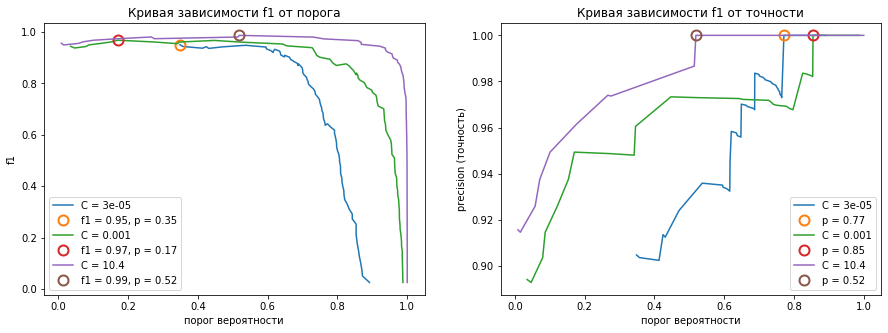

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for c in [0.00003, 0.001, 10.4]:
    log_reg = LogisticRegression(C = c).fit(X_train,y_train)
    precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])
    f_scores = []
    for i in tresholds:
        y_pred_change_threshold = log_reg.predict_proba(X_valid) >= i
        f_scores.append(f1_score(y_valid,y_pred_change_threshold[:,1]))
    max_f1 = np.argmax(np.abs(f_scores))
    axes[0].plot(tresholds, f_scores, label = 'C = {}'.format(c))
    axes[0].plot(tresholds[max_f1], f_scores[max_f1],'o', markersize=10, 
             label="f1 = {:.2f}, p = {:.2f}".format(f_scores[max_f1],tresholds[max_f1]), 
             fillstyle="none",mew=2)
    axes[0].set_title('Кривая зависимости f1 от порога')
    axes[0].set_xlabel('порог вероятности')
    axes[0].set_ylabel('f1')
    axes[0].legend(loc = 'best')    

    max_precision = np.argmax(np.abs(precision))
    axes[1].plot(tresholds, precision[:-1], label = 'C = {}'.format(c))
    axes[1].plot(tresholds[max_precision], precision[:-1][max_precision],'o', markersize=10, 
             label="p = {:.2f}".format(tresholds[max_precision]), fillstyle="none",mew=2)
    axes[1].set_title('Кривая зависимости f1 от точности')
    axes[1].set_xlabel('порог вероятности')
    axes[1].set_ylabel('precision (точность)')
    axes[1].legend(loc = 'best')     
plt.show()

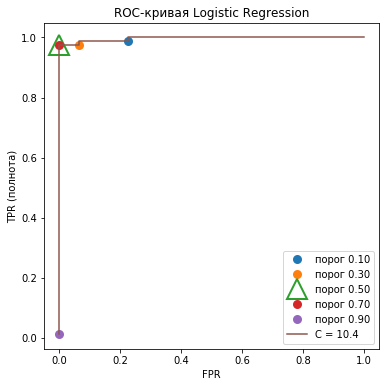

In [218]:
rcParams['figure.figsize'] = 6, 6
log_reg = LogisticRegression(C = 10.04).fit(X_train,y_train)
fpr, recall, tresholds = roc_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])
probability = np.arange(0.1,1,0.2)
for p in probability:
    if round(p,1) == 0.5:
        close_point = np.argmin(np.abs(tresholds - p))
        plt.plot(fpr[close_point], recall[close_point], '^', markersize=20, 
                 label="порог {:.2f}".format(p),fillstyle="none",mew=2)
    else:
        close_point = np.argmin(np.abs(tresholds - p))
        plt.plot(fpr[close_point], recall[close_point], 'o', markersize=7, 
                 label="порог {:.2f}".format(p), mew=2)
plt.plot(fpr, recall, label= 'C = {}'.format(c))
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
plt.title('ROC-кривая Logistic Regression')
plt.legend(loc='best')
plt.show()

На графике видно, что при пороге вероятности = 0.5 модель достигает почти идеальных значений для f меры  и наибольшей точности с нулевым кол-вом ложно-положитеьных результатов (т.е. нет меток, которые модель определила бы как 1, а она оказалась 0). 

## Размер контрольного множества

In [288]:
#Разбивка данных на обчающий и тестовый наборы с разной величиной контрольной выборки
def procent_of_test_size(control_sizes, data, target):
    scores = []
    data_strucrure = {'%_test_size': ['original'],  # формируем имена колонок
                      'train_size':[cancer.data.shape[0]],
                      'test_size': [cancer.data.shape[0]] , 
                      'mean': [round(np.mean(data))] , 
                      'var': [round(np.var(data))] ,
                      'score': [0]}
    df = pd.DataFrame(data_strucrure)        # создаем датафрейм 
      
    for size in control_sizes:
        train_size = 1 - size
        test_percent = size*100
        X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, 
                                                                  stratify = target, 
                                                                  random_state = 0,
                                                                  test_size = size,
                                                                  train_size = train_size)
        train_size = X_trainval.shape 
        test_size = X_test.shape
        mean = np.mean(X_trainval)
        var = np.var(X_trainval)
    
        
        log_reg = LogisticRegression(C = 10.04)
        kf = KFold(n_splits=12)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
        score = np.mean(scor)
        scores.append(score)
    
    
        new_row = {'%_test_size': test_percent, 
                   'train_size': train_size[0], 
                   'test_size': test_size[0], 
                   'mean': round(mean,2), 
                   'var': round(var,2),
                   'score': round(score,3)}
        
        
        df = df.append(new_row, ignore_index=True)
    
    return df

In [289]:
control_sizes = np.arange(0.1,1.0,0.05)
cancer_data_df = procent_of_test_size(control_sizes,cancer.data, cancer.target )

In [290]:
print(cancer_data_df)

   %_test_size  train_size  test_size   mean       var  score
0     original       569.0      569.0  62.00  52120.00  0.000
1           10       512.0       57.0  62.12  52900.28  0.955
2           15       483.0       86.0  62.12  53115.51  0.957
3           20       455.0      114.0  62.10  53276.72  0.958
4           25       426.0      143.0  61.79  52577.18  0.967
5           30       398.0      171.0  61.73  52504.21  0.970
6           35       369.0      200.0  61.67  52699.77  0.957
7           40       341.0      228.0  61.88  53446.57  0.968
8           45       312.0      257.0  62.04  54202.32  0.958
9           50       284.0      285.0  62.03  54157.80  0.954
10          55       256.0      313.0  62.37  55606.89  0.949
11          60       227.0      342.0  62.63  56527.47  0.939
12          65       199.0      370.0  61.38  53784.77  0.955
13          70       170.0      399.0  60.54  51196.12  0.947
14          75       142.0      427.0  61.12  52242.24  0.951
15      

In [291]:
print('max mean value:',cancer_data_df["mean"].max())
print('min mean value:',cancer_data_df["mean"].min())

print()

print('max variance value:',cancer_data_df["var"].max())
print('min variance value:',cancer_data_df["var"].min())

max mean value: 63.13
min mean value: 54.76

max variance value: 59118.88
min variance value: 37708.48


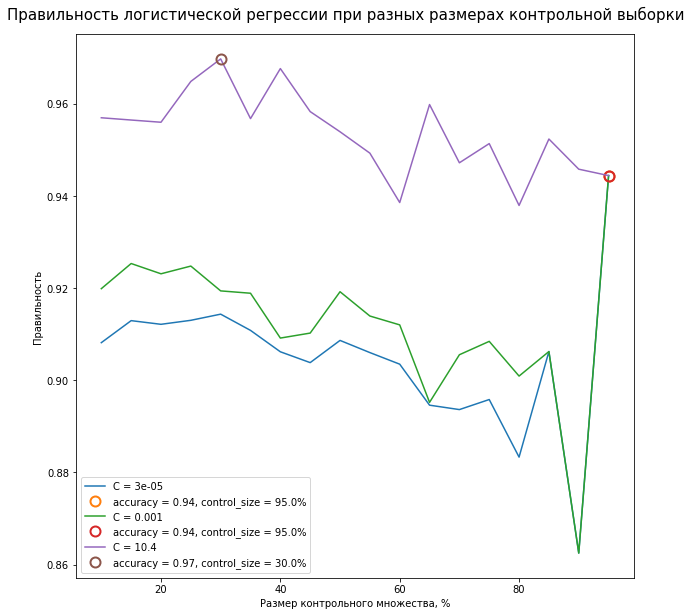

In [316]:
control_sizes = np.arange(0.1,1.0,0.05)
for c in [0.00003, 0.001, 10.4]:
    scores = []
    for size in control_sizes:
        train_size = 1 - size
        test_percent = size*100
        X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                                  stratify = cancer.target, 
                                                                  random_state = 0,test_size = size, train_size = train_size)
      
        log_reg = LogisticRegression(C = c)
        kf = KFold(n_splits=12)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
        scores.append(np.mean(scor))
    
    
      
    max_accuracy = np.argmax(scores) 
    plt.plot(control_sizes*100, scores, label = 'C = {}'.format(c))
    plt.plot(control_sizes[max_accuracy]*100, scores[max_accuracy], 'o', fillstyle="none",markersize=10, mew = 2,
             label = 'accuracy = {:.2f}, control_size = {:.1f}%'.format(scores[max_accuracy],control_sizes[max_accuracy]*100))
rcParams['figure.figsize'] = 10, 10
plt.ylabel("Правильность")
plt.xlabel("Размер контрольного множества, %")
plt.figtext(0.5,0.9,'Правильность логистической регрессии при разных размерах контрольной выборки', fontsize=15, ha='center')
plt.legend(loc='best')     
plt.show()   

# Отбор значимых признаков (PCA) и классификация

### PCA

In [430]:
from sklearn.preprocessing import StandardScaler

In [431]:
# разбиваем выборку на тренировочный и тестовый наборы 
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)

# масштабируем данные, чтобы они имели var = 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [432]:
np.var(X_train_scaled)

1.0000000000000002

In [434]:
# применяем метод PCA (главныйх компонент), чтобы снизить размерность данных (с меньшей потерей информации)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_train_scaled) # оставляем 2 главные компоненты, 
                                                # чтобы данные можно было отрисовать график

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Форма исходного массива: {}".format(str(X_train_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_train_pca.shape)))


Форма исходного массива: (426, 30)
Форма массива после сокращения размерности: (426, 2)


Text(0, 0.5, 'Вторая главная компонента')

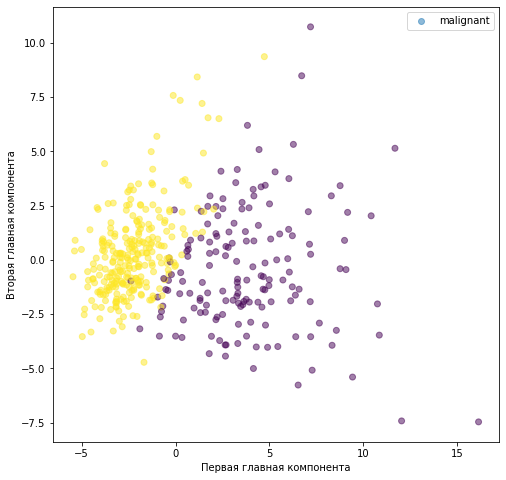

In [435]:
# строим график 
plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c = y_train, alpha= 0.5)

plt.legend(cancer.target_names)

plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")

In [436]:
# Теперь мы можем использовать новое представление, чтобы классифицировать данные
# используя классификатор LinearSVC

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train_pca,y_train)

print("Правильность на обучающем наборе: {:.2f}".format(clf.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(clf.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 0.96
Правильность на тестовом наборе: 0.93


In [437]:
# метод k ближайших соседей

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_pca,y_train)
print("Правильность на обучающем наборе: {:.2f}".format(knn.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(knn.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 1.00
Правильность на тестовом наборе: 0.90


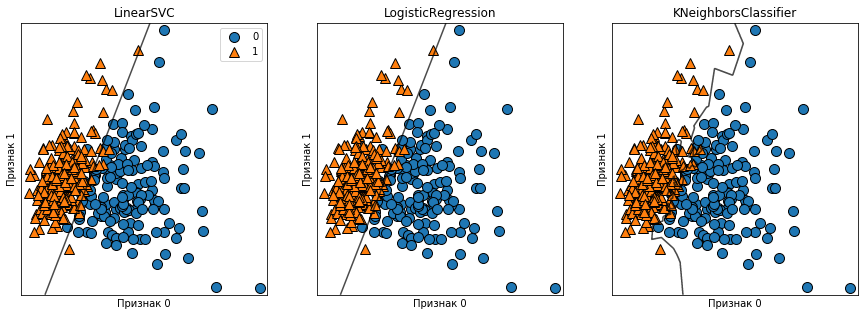

In [438]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for model, ax in zip([LinearSVC(), LogisticRegression(C = 4.6),KNeighborsClassifier(n_neighbors=1)], axes):
    clf = model.fit(X_train_pca, y_train)
    mglearn.plots.plot_2d_separator(clf, X_train_pca, fill=False, eps=0.5, ax=ax, alpha=.7)
    mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel("Признак 0")
    ax.set_ylabel("Признак 1")
axes[0].legend()
plt.show()

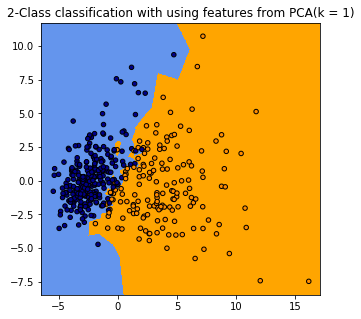

In [444]:
# Отрисуем метод одного ближайшего соседа более подробно

from sklearn import neighbors
n_neighbors = 1

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max()) 
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification with using features from PCA(k = %i)"
% (n_neighbors))

plt.show()

При методе  k ближайших соседей  модель хорошо предсказывает данные на тренировочных данных (100%), но имеет более низкую обобщающую способность (90%). По графикам видно, что модель переобучена.

 На графиках также видно, что метод опорных векторов и логистическая регрессия не сильно отличаются и должны довать схожий результат.
Так оно и есть. 
При методе опорных векторов на тестовой выборке правильность = 96%, на тренировочной = 93%.
При линейной регрессии на тестовой выборке правильность = 97%,  на тренировочной= 94%.
Таким образом, использование логистической регрессии для классификации данного датасета яв-ся более целесообразным.

# GaussianNB

In [446]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify = cancer.target, random_state = 0)


In [447]:
# стандартиируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [448]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_scaled, y_train)

print("Правильность на обучающем наборе: {:.2f}".format(clf.score(X_train_scaled, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 0.93
Правильность на тестовом наборе: 0.91
